# Importing Brevitas networks into FINN

In this notebook we'll go through an example of how to import a Brevitas-trained QNN into FINN. The steps will be as follows:

1. Load up the trained PyTorch model
2. Call Brevitas FINN-ONNX export and visualize with Netron
3. Import into FINN and call cleanup transformations

We'll use the following showSrc function to print the source code for function calls in the Jupyter notebook:

In [2]:
import inspect

def showSrc(what):
    print("".join(inspect.getsourcelines(what)[0]))

## 1. Load up the trained PyTorch model

The FINN Docker image comes with several [example Brevitas networks](https://github.com/maltanar/brevitas_cnv_lfc), and we'll use the LFC-w1a1 model as the example network here. This is a binarized fully connected network trained on the MNIST dataset. Let's start by looking at what the PyTorch network definition looks like:

In [3]:
from models.LFC import LFC
showSrc(LFC)

class LFC(Module):

    def __init__(self, num_classes=10, weight_bit_width=None, act_bit_width=None,
                 in_bit_width=None, in_ch=1, in_features=(28, 28)):
        super(LFC, self).__init__()

        weight_quant_type = get_quant_type(weight_bit_width)
        act_quant_type = get_quant_type(act_bit_width)
        in_quant_type = get_quant_type(in_bit_width)
        stats_op = get_stats_op(weight_quant_type)

        self.features = ModuleList()
        self.features.append(get_act_quant(in_bit_width, in_quant_type))
        self.features.append(Dropout(p=IN_DROPOUT))
        in_features = reduce(mul, in_features)
        for out_features in FC_OUT_FEATURES:
            self.features.append(get_quant_linear(in_features=in_features,
                                                  out_features=out_features,
                                                  per_out_ch_scaling=INTERMEDIATE_FC_PER_OUT_CH_SCALING,
                                                  bit_width=w

We can see that the network topology is constructed using a few helper functions that generate the quantized linear layers and quantized activations. The bitwidth of the layers is actually parametrized in the constructor, so let's instantiate a 1-bit weights and activations version of this network. We also have pretrained weights for this network, which we will load into the model.

In [4]:
import torch

trained_lfc_w1a1_checkpoint = "/workspace/brevitas_cnv_lfc/pretrained_models/LFC_1W1A/checkpoints/best.tar"
lfc = LFC(weight_bit_width=1, act_bit_width=1, in_bit_width=1).eval()
checkpoint = torch.load(trained_lfc_w1a1_checkpoint, map_location="cpu")
lfc.load_state_dict(checkpoint["state_dict"])
lfc

LFC(
  (features): ModuleList(
    (0): QuantHardTanh(
      (act_quant_proxy): ActivationQuantProxy(
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): ClampedBinaryQuant(
            (scaling_impl): StandaloneScaling(
              (restrict_value): RestrictValue(
                (forward_impl): Sequential(
                  (0): PowerOfTwo()
                  (1): ClampMin()
                )
              )
            )
          )
        )
      )
    )
    (1): Dropout(p=0.2)
    (2): QuantLinear(
      in_features=784, out_features=1024, bias=False
      (weight_reg): WeightReg()
      (weight_quant): WeightQuantProxy(
        (tensor_quant): BinaryQuant(
          (scaling_impl): ParameterStatsScaling(
            (parameter_list_stats): ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper()
              (stats): Stats(
                (stats_impl): AbsAve()
          

We have now instantiated our trained PyTorch network. Let's try to run an example MNIST image through the network using PyTorch.

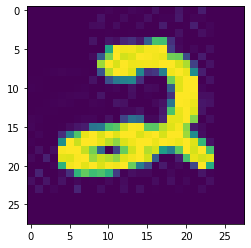

In [6]:
import matplotlib.pyplot as plt
from pkgutil import get_data
import onnx
import onnx.numpy_helper as nph
raw_i = get_data("finn", "data/onnx/mnist-conv/test_data_set_0/input_0.pb")
input_tensor = onnx.load_tensor_from_string(raw_i)
input_tensor_npy = nph.to_array(input_tensor)
input_tensor_pyt = torch.from_numpy(input_tensor_npy).float()
imgplot = plt.imshow(input_tensor_npy.reshape(28,28))

In [7]:
from torch.nn.functional import softmax
# do forward pass in PyTorch/Brevitas
produced = lfc.forward(input_tensor_pyt).detach()
probabilities = softmax(produced, dim=-1).flatten()
probabilities

tensor([2.4663e-03, 6.8211e-06, 8.9177e-01, 2.1330e-05, 3.6883e-04, 3.0418e-06,
        1.1795e-04, 5.0158e-05, 1.0517e-01, 2.4597e-05])

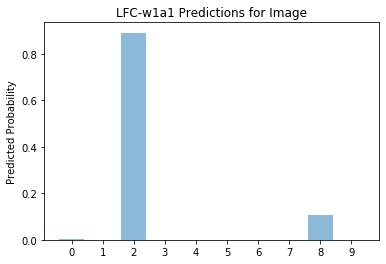

In [8]:
import numpy as np
objects = [str(x) for x in range(10)]
y_pos = np.arange(len(objects))
plt.bar(y_pos, probabilities, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Predicted Probability')
plt.title('LFC-w1a1 Predictions for Image')
plt.show()

## 2. Call Brevitas FINN-ONNX export and visualize with Netron

Brevitas comes with built-in FINN-ONNX export functionality. This is similar to the regular ONNX export capabilities of PyTorch, with a few differences:

1. The weight quantization logic is not exported as part of the graph; rather, the quantized weights themselves are exported.
2. Special quantization annotations are used to preserve the low-bit quantization information. ONNX (at the time of writing) supports 8-bit quantization as the minimum bitwidth, whereas FINN-ONNX quantization annotations can go down to binary/bipolar quantization.
3. Low-bit quantized activation functions are exported as MultiThreshold operators.

It's actually quite straightforward to export ONNX from our Brevitas model as follows:

In [9]:
import brevitas.onnx as bo
export_onnx_path = "/tmp/LFCW1A1.onnx"
input_shape = (1, 1, 28, 28)
bo.export_finn_onnx(lfc, input_shape, export_onnx_path)

/workspace/brevitas_cnv_lfc/training_scripts/models/LFC.py:73: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = 2.0 * x - torch.tensor([1.0])


Let's examine what the exported ONNX model looks like. For this, we will use the Netron visualizer:

In [10]:
import netron
netron.start(export_onnx_path, port=8081, host="0.0.0.0")

Serving '/tmp/LFCW1A1.onnx' at http://0.0.0.0:8081


In [11]:
%%html
<iframe src="http://0.0.0.0:8081/" style="position: relative; width: 100%;" height="400"></iframe>

When running this notebook in the FINN Docker container, you should be able to see an interactive visualization of the imported network above, and click on individual nodes to inspect their parameters. If you look at any of the MatMul nodes, you should be able to see that the weights are all {-1, +1} values, and the activations are Sign functions.

## 3. Import into FINN and call cleanup transformations

We will now import this ONNX model into FINN using the ModelWrapper, and examine some of the graph attributes from Python.

In [22]:
from finn.core.modelwrapper import ModelWrapper
model = ModelWrapper(export_onnx_path)
model.graph.node[9]

input: "32"
input: "33"
output: "35"
op_type: "MatMul"

The ModelWrapper exposes a range of other useful functions as well. For instance, by convention the second input of the MatMul node will be a pre-initialized weight tensor, which we can view using the following:

In [23]:
model.get_initializer(model.graph.node[9].input[1])

array([[ 1.,  1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ..., -1.,  1., -1.],
       ...,
       [-1.,  1., -1., ..., -1., -1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       [-1.,  1.,  1., ..., -1., -1.,  1.]], dtype=float32)

We can also examine the quantization annotations and shapes of various tensors using the convenience functions provided by ModelWrapper.

In [24]:
model.get_tensor_datatype(model.graph.node[9].input[1])

<DataType.BIPOLAR: 8>

In [25]:
model.get_tensor_shape(model.graph.node[9].input[1])

[784, 1024]

If we want to operate further on this model in FINN, it is a good idea to execute certain "cleanup" transformations on this graph. Here, we will run shape inference and constant folding on this graph, and visualize the resulting graph in Netron again.

In [14]:
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.infer_shapes import InferShapes
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
export_onnx_path_transformed = "/tmp/LFCW1A1-clean.onnx"
model.save(export_onnx_path_transformed)
netron.start(export_onnx_path_transformed, port=8081, host="0.0.0.0")


Stopping http://0.0.0.0:8081
Serving '/tmp/LFCW1A1-clean.onnx' at http://0.0.0.0:8081


In [15]:
%%html
<iframe src="http://0.0.0.0:8081/" style="position: relative; width: 100%;" height="400"></iframe>

We can see that the resulting graph has become smaller and simpler. Specifically, the input reshaping is now a single Reshape node instead of the Shape -> Gather -> Unsqueeze -> Concat -> Reshape sequence. We can now use the internal ONNX execution capabilities of FINN to ensure that we still get the same output from this model as we did with PyTorch.

In [18]:
import finn.core.onnx_exec as oxe
input_dict = {"0": nph.to_array(input_tensor)}
output_dict = oxe.execute_onnx(model, input_dict)
produced_finn = output_dict[list(output_dict.keys())[0]]

produced_finn

array([[ 3.3252678 , -2.5652065 ,  9.215742  , -1.4251148 ,  1.4251148 ,
        -3.3727715 ,  0.28502294, -0.5700459 ,  7.07807   , -1.2826033 ]],
      dtype=float32)

In [19]:
np.isclose(produced, produced_finn).all()

True

We have succesfully verified that the transformed and cleaned-up FINN graph still produces the same output, and can now use this model for further processing in FINN.